In [195]:
import sys

sys.path.append("../")

In [196]:
import glob
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [197]:
%config InlineBackend.figure_format = 'retina'

In [209]:
EXPERIMENT_NAME = "multiple_iterations"

NUM_ITERATIONS = 4

In [210]:
EXPERIMENT_DIR = "../experiments_iterative"
DOMAINS_DIR = "domains"

COMPUTE_LIKELIHOODS = False

In [211]:
# laps domains
# DOMAIN = "logo"
# DOMAIN = "clevr"
# DOMAIN = "re2"

# drawings domains
# DOMAIN = "drawings_nuts_bolts"
# DOMAIN = "drawings_furniture"
# DOMAIN = "drawings_dials"
DOMAIN = "drawings_wheels"

CONDITION_STITCH = "stitch"
CONDITION_STITCH_CODEX = "stitch_codex"
CONDITION_STITCH_CODEX_LANGUAGE = "stitch_codex_language"
CONDITION_STITCH_CODEX_LANGUAGE_ORIGIN_RANDOM_TEST = "stitch_codex_language_origin_random_test"
CONDITION_ORACLE = "oracle"
CONDITION_ORACLE_TRAIN_TEST = "oracle_train_test"

RANDOM_SEEDS = []
# RANDOM_SEEDS = [111]

# ERROR_BAR_COL = "task_name"  # Error bars will show variation across tasks; results from different random seeds will be averaged
ERROR_BAR_COL = "random_seed" # Error bars will show variation across random seeds; results from different tasks will be averaged

In [212]:
os.makedirs(os.path.join(DOMAINS_DIR, DOMAIN), exist_ok=True)

In [213]:
NUMERIC_SORT = lambda x: (len(x), x)

In [214]:
def get_log_likelihoods(condition, split):
    results_pattern = os.path.join(
        EXPERIMENT_DIR, "outputs", EXPERIMENT_NAME, "domains", DOMAIN, condition, f"seed_*"
    )

    seed_paths = sorted(glob.glob(results_pattern), key=NUMERIC_SORT)
    if not seed_paths:
        raise ValueError(results_pattern)

    df_list = []
    for seed_path in seed_paths:
        random_seed = int(seed_path[len(results_pattern) - 1 :])

        if len(RANDOM_SEEDS) > 0 and random_seed not in RANDOM_SEEDS:
            continue

        print(f"Condition: {condition}, split: {split}, seed: {random_seed}")

        df = get_log_likelihoods_single_replication(condition, split, random_seed)
        df["random_seed"] = random_seed
        df_list.append(df)

    df_concat = pd.concat(df_list, axis=0).reset_index(drop=True)

    # Compute the mean over replications
    AGG_COLS = ["n_frontiers", "description_length"]
    if COMPUTE_LIKELIHOODS:
        AGG_COLS += ["log_likelihood"]
    df_out = df_concat.groupby(
        ["batch_size", ERROR_BAR_COL], sort=False, as_index=False
    )[AGG_COLS].mean()

    return df_out


def get_log_likelihoods_single_replication(condition, split, random_seed):
    data = []

    results_pattern = os.path.join(
        EXPERIMENT_DIR,
        "outputs",
        EXPERIMENT_NAME,
        "domains",
        DOMAIN,
        condition,
        f"seed_{random_seed}",
        f"{condition}_*",
    )

    for path in sorted(glob.glob(results_pattern), key=NUMERIC_SORT):
        config_json_path = os.path.join(path, "config.json")
        if not os.path.exists(config_json_path):
            continue
        with open(config_json_path, "r") as f:
            config = json.load(f)
        global_batch_size = config["experiment_iterator"]["task_batcher"]["params"][
            "global_batch_size"
        ]

        test_likelihoods_json_path = os.path.join(path, str(NUM_ITERATIONS), "test_likelihoods.json")
        if not os.path.exists(test_likelihoods_json_path):
            continue
        with open(test_likelihoods_json_path, "r") as f:
            likelihoods_data = json.load(f)

        stitch_frontiers_json_path = os.path.join(
            path, str(NUM_ITERATIONS), split, "stitch_frontiers.json"
        )
        if not os.path.exists(stitch_frontiers_json_path):
            continue
        with open(stitch_frontiers_json_path, "r") as f:
            stitch_frontiers_data = json.load(f)

        for task_name, dl_list in likelihoods_data["description_lengths_by_task"][
            "test"
        ].items():
            d = {
                "batch_size": global_batch_size,
                "task_name": task_name,
                "description_length": dl_list[0],
                "n_frontiers": len(stitch_frontiers_data["frontiers"]),
            }
            if COMPUTE_LIKELIHOODS:
                d["log_likelihood"] = likelihoods_data["log_likelihoods_by_task"][
                    "test"
                ][task_name][0]

            data.append(d)

    df = pd.DataFrame(data)
    return df

In [215]:
df_stitch = get_log_likelihoods(CONDITION_STITCH, "train")
df_stitch["condition"] = "Stitch"

df_stitch_codex = get_log_likelihoods(CONDITION_STITCH_CODEX, "train")
df_stitch_codex["condition"] = "Stitch + Codex"

# df_stitch_codex_language = get_log_likelihoods(CONDITION_STITCH_CODEX_LANGUAGE, "train")
# df_stitch_codex_language["condition"] = "Stitch + Codex + Language (train)"
# df_stitch_codex_language["language"] = True

# df_stitch_codex_language_origin_random_test = get_log_likelihoods(CONDITION_STITCH_CODEX_LANGUAGE_ORIGIN_RANDOM_TEST, "train")
# df_stitch_codex_language_origin_random_test["condition"] = "Stitch + Codex + Language (test)"
# df_stitch_codex_language_origin_random_test["language"] = True

df_oracle = get_log_likelihoods(CONDITION_ORACLE, "test")
df_oracle["condition"] = "Oracle (test)"

# df_oracle_train_test = get_log_likelihoods(CONDITION_ORACLE_TRAIN_TEST, "train_test")
# df_oracle_train_test["condition"] = "Oracle (train + test)"

Condition: stitch, split: train, seed: 111
Condition: stitch_codex, split: train, seed: 0
Condition: stitch_codex, split: train, seed: 111
Condition: oracle, split: test, seed: 111


In [216]:
df = pd.concat([df_stitch, df_stitch_codex, df_oracle], axis=0).reset_index(drop=True)
df.batch_size = df.batch_size.astype(int)
BATCH_SIZES = sorted(df.batch_size.unique().tolist())
BATCH_SIZES

[5, 10, 15, 25, 50, 100, 150, 200]

In [217]:
df

,batch_size,random_seed,n_frontiers,description_length,condition
0,5,111,5.0,218.04,Stitch
1,10,111,10.0,188.02,Stitch
2,15,111,15.0,161.50,Stitch
3,25,111,25.0,172.06,Stitch
4,50,111,50.0,153.70,Stitch
5,100,111,100.0,115.48,Stitch
6,150,111,150.0,92.86,Stitch
7,200,111,200.0,88.24,Stitch
8,5,111,19.0,205.18,Stitch + Codex
9,10,111,20.0,176.24,Stitch + Codex


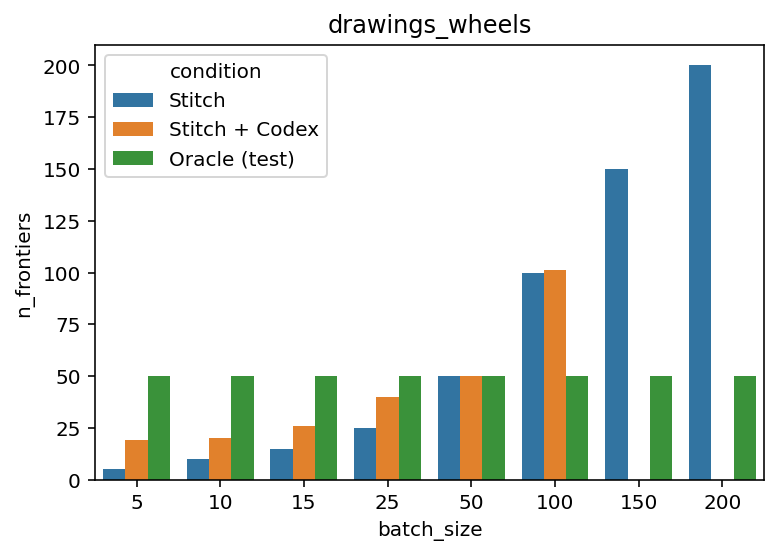

In [220]:
plt.title(DOMAIN);
sns.barplot(data=df, x="batch_size", y="n_frontiers", hue="condition");

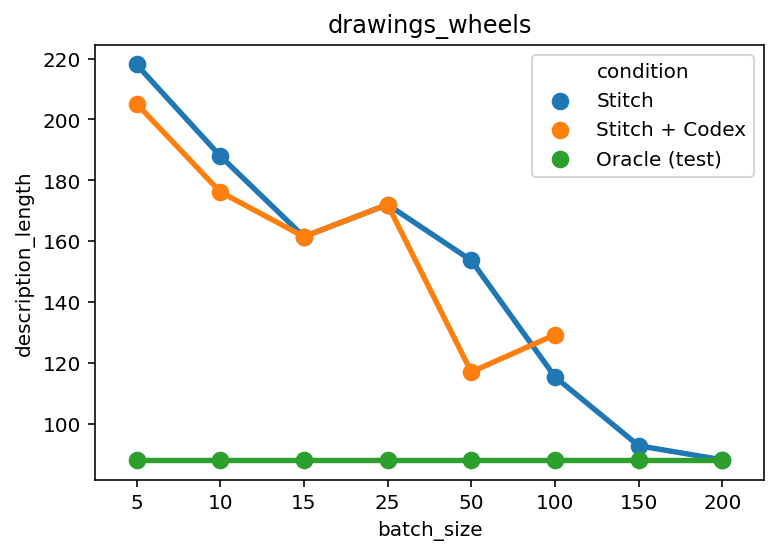

In [219]:
plt.title(DOMAIN);
sns.pointplot(data=df, x="batch_size", y="description_length", hue="condition");
plt.savefig(os.path.join(DOMAINS_DIR, DOMAIN, f"description_length.png"), dpi=300);

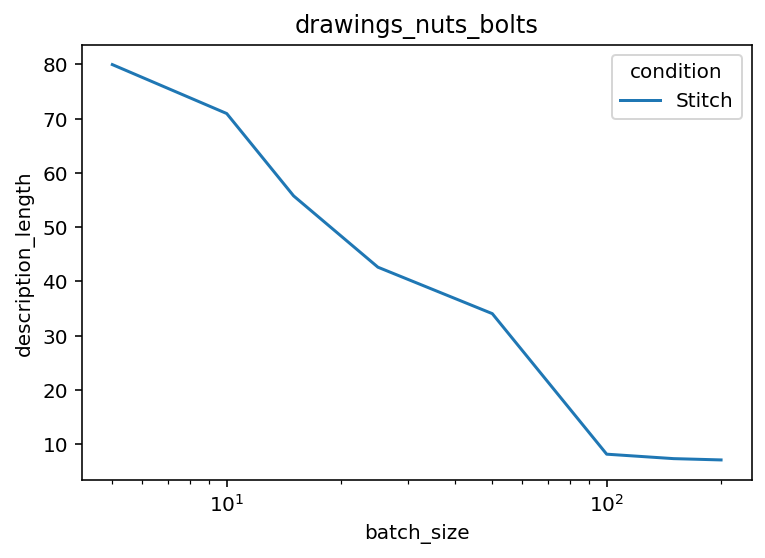

In [107]:
plt.title(DOMAIN);
g = sns.lineplot(data=df, x="batch_size", y="description_length", hue="condition")
g.set(xscale="log");
plt.savefig(os.path.join(DOMAINS_DIR, DOMAIN, f"description_length_logscale.png"), dpi=300);

In [ ]:
plt.title("Drawings: nuts-bolts");
g = sns.pointplot(data=df[df.condition.isin(["Stitch", "Stitch + Codex", "Stitch + Codex + Language (train)", "Oracle (test)"])], x="batch_size", y="description_length", hue="condition");
plt.xlabel("Training Examples (ordered by complexity)")
plt.ylabel("Program Description Length")
plt.savefig(os.path.join(DOMAINS_DIR, DOMAIN, f"description_length_camera_ready.png"), dpi=300);

In [ ]:
plt.title("Drawings: nuts-bolts");
g = sns.lineplot(data=df[df.condition.isin(["Stitch", "Stitch + Codex", "Stitch + Codex + Language (train)", "Oracle (test)"])], x="batch_size", y="description_length", hue="condition");
plt.xlabel("Training Examples (ordered by complexity)")
plt.ylabel("Program Description Length")
g.set(xscale="log");
plt.savefig(os.path.join(DOMAINS_DIR, DOMAIN, f"description_length_logscale_camera_ready.png"), dpi=300);

In [ ]:
if COMPUTE_LIKELIHOODS:
    plt.title(DOMAIN);
    sns.pointplot(data=df, x="batch_size", y="log_likelihood", hue="condition")
    plt.savefig(os.path.join(DOMAINS_DIR, DOMAIN, f"likelihood.png"), dpi=300);

In [ ]:
if COMPUTE_LIKELIHOODS:
    plt.title(DOMAIN);
    g = sns.lineplot(data=df, x="batch_size", y="log_likelihood", hue="condition")
    g.set(xscale="log");
    plt.savefig(os.path.join(DOMAINS_DIR, DOMAIN, f"likelihood_logscale.png"), dpi=300);

In [ ]:
if COMPUTE_LIKELIHOODS:
    plt.title(DOMAIN);
    sns.scatterplot(
        data=df, x="description_length", y="log_likelihood", hue="condition", alpha=0.25
    )
    plt.savefig(os.path.join(DOMAINS_DIR, DOMAIN, f"description_length_vs_likelihood.png"), dpi=300);

# What programs does Codex generate?

In [ ]:
def get_codex_programs():
    results_pattern = os.path.join(
        EXPERIMENT_DIR, "outputs", EXPERIMENT_NAME, "domains", DOMAIN, CONDITION_STITCH_CODEX, f"seed_*"
    )
    seed_paths = sorted(glob.glob(results_pattern), key=NUMERIC_SORT)
    if not seed_paths:
        raise ValueError(results_pattern)
    print(seed_paths)

    df_list = []

    for seed_path in seed_paths:
        random_seed = int(seed_path[len(results_pattern) - 1 :])

        for batch_size in BATCH_SIZES:
            path = os.path.join(
                seed_path,
                f"{CONDITION_STITCH_CODEX}_{batch_size}/0/codex_query_results.json",
            )
            
            if not os.path.exists(path):
                print(f"Skipped nonexisten {path}")
                continue

            with open(path, "r") as f:
                codex_query_results = json.load(f)

            data = []
            for query_data in codex_query_results["results_by_query"]:
                for body_task_data in query_data["prompt"]["body_task_data"]:
                    body_task_data["query_id"] = query_data["query_id"]
                    body_task_data["program"] = body_task_data["task_program"]
                    body_task_data.pop("task_program")
                    body_task_data["origin"] = "train"
                    body_task_data["final_task"] = False
                    body_task_data["valid"] = True
                    body_task_data["seed"] = random_seed
                    data.append(body_task_data)
                
                if "programs" in codex_query_results["params"]["final_task_types"]:
                    final_task_data = query_data["prompt"]["final_task_data"]
                    final_task_data["query_id"] = query_data["query_id"]
                    final_task_data["program"] = "task_program"
                    final_task_data.pop("task_program")
                    final_task_data["origin"] = "train"
                    final_task_data["final_task"] = True
                    final_task_data["valid"] = True
                    final_task_data["seed"] = random_seed
                    data.append(final_task_data)
                    
                for parse_result_data in query_data["parse_results"]:
                    parse_result_data["origin"] = "codex"
                    parse_result_data["final_task"] = False
                    parse_result_data["seed"] = random_seed
                    if not parse_result_data["valid"]:
                        parse_result_data["program"] = parse_result_data["text"]
                    data.append(parse_result_data)


            df = pd.DataFrame(data)
            df["program_str_len"] = df.program.str.len()
            df["batch_size"] = batch_size
            df["random_seed"] = random_seed

            tps = df[df["origin"] == "train"]["program"]

            train_programs = set(df[df["origin"] == "train"]["program"].tolist())
            df["copied_from_train"] = [
                (row["origin"] == "codex") and (row["program"] in train_programs)
                for _, row in df.iterrows()
            ]

            df_list.append(df)

    return pd.concat(df_list).reset_index(drop=True)

In [ ]:
df_codex = get_codex_programs()

In [ ]:
df_codex

In [ ]:
plt.title("Percentage of valid programs")
sns.barplot(data=df_codex, x="batch_size", y="valid", hue="origin");

In [ ]:
plt.title("Program string length")
sns.violinplot(data=df_codex, x="batch_size", y="program_str_len", hue="origin");

In [ ]:
plt.title("Count of unique programs")

df_tmp1 = df_codex.query("origin == 'train'").groupby(["batch_size", "seed"]).nunique().reset_index()
df_tmp2 = df_codex.query("origin == 'codex'").groupby(["batch_size", "seed"]).nunique().reset_index()
df_tmp3 = df_codex.query("origin == 'codex' & copied_from_train").groupby(["batch_size", "seed"]).nunique().reset_index()
df_tmp4 = df_codex.query("origin == 'codex' & ~copied_from_train").groupby(["batch_size", "seed"]).nunique().reset_index()
df_tmp1["origin"] = "train"
df_tmp2["origin"] = "codex (overall)"
df_tmp3["origin"] = "codex (copied from train)"
df_tmp4["origin"] = "codex (original)"

df_tmp = pd.concat([df_tmp1, df_tmp2, df_tmp3, df_tmp4], axis=0).reset_index()

sns.pointplot(data=df_tmp, x="batch_size", y="program", hue="origin");

In [ ]:
plt.title("Count of programs copied from train")
sns.pointplot(
    data=df_codex.groupby(["batch_size", "seed"]).sum().reset_index(),
    x="batch_size",
    y="copied_from_train",
);

In [ ]:
df_codex["valid"].value_counts()

In [ ]:
# This plot takes a while to render

# sns.displot(
#     data=df_codex, x="program_str_len", hue="valid", col="origin", row="batch_size"
# );

# What inventions are in the libraries?

In [ ]:
def get_library_inventions(condition, split, seed):
    data = []
    for batch_size in BATCH_SIZES:
        path = os.path.join(
            EXPERIMENT_DIR,
            "outputs",
            EXPERIMENT_NAME,
            "domains",
            DOMAIN,
            condition,
            f"seed_{seed}",
            f"{condition}_{batch_size}",
            "0",
            split,
            "stitch_output.json",
        )
        # path = f"../experiments/outputs/{DOMAIN}/{experiment_id}/{experiment_id}_{batch_size}/0/{split}/stitch_output.json"

        with open(path, "r") as f:
            stitch_output_data = json.load(f)

        df = pd.DataFrame(stitch_output_data["invs"])[
            ["name", "arity", "utility", "multiplier", "body", "dreamcoder"]
        ]
        df["batch_size"] = batch_size
        data.append(df)

    return pd.concat(data, axis=0).reset_index(drop=True)

In [ ]:
SEED_BASELINE = 111
SEED_CODEX = 111

df_libraries_baseline = get_library_inventions(CONDITION_STITCH, "train", seed=SEED_BASELINE)
df_libraries_baseline["condition"] = "baseline"

df_libraries_codex = get_library_inventions(CONDITION_STITCH_CODEX, "train", seed=SEED_CODEX)
df_libraries_codex["condition"] = "codex"

df_libraries_test = get_library_inventions(CONDITION_ORACLE, "test", seed=SEED_BASELINE)
df_libraries_test["condition"] = "test"

df_libraries = pd.concat(
    [df_libraries_baseline, df_libraries_codex, df_libraries_test], axis=0
).reset_index(drop=True)

In [ ]:
data_overlap = []
for batch_size, group in df_libraries.groupby("batch_size"):
    fns_baseline = set(group[group.condition == "baseline"].dreamcoder)
    fns_codex = set(group[group.condition == "codex"].dreamcoder)
    fns_test = set(group[group.condition == "test"].dreamcoder)
    data_overlap.append(
        {
            "batch_size": int(batch_size),
            "utility_baseline": group[group.condition == "baseline"]["utility"].sum(),
            "utility_codex": group[group.condition == "codex"]["utility"].sum(),
            "utility_test": group[group.condition == "test"]["utility"].sum(),
            "n_baseline": len(fns_baseline),
            "fns_baseline": fns_baseline,
            "n_codex": len(fns_codex),
            "fns_codex": fns_codex,
            "n_test": len(fns_test),
            "fns_test": fns_test,
            "n_baseline_only": len(fns_baseline - fns_codex),
            "fns_baseline_only": fns_baseline - fns_codex,
            "n_codex_only": len(fns_codex - fns_baseline),
            "fns_codex_only": fns_codex - fns_baseline,
            "n_overlap": len(fns_baseline & fns_codex),
            "fns_overlap": (fns_baseline & fns_codex),
            "n_baseline_test": len(fns_baseline & fns_test),
            "n_codex_test": len(fns_codex & fns_test),
        }
    )

In [ ]:
df_overlap = pd.DataFrame(data_overlap)
df_overlap

In [ ]:
df_overlap_long = df_overlap.rename(
    dict(
        zip(
            ["n_baseline_only", "n_codex_only", "n_overlap"],
            ["baseline_only", "codex_only", "overlap"],
        )
    ),
    axis="columns",
)
df_overlap_long = df_overlap_long.melt(
    id_vars="batch_size",
    value_vars=["baseline_only", "codex_only", "overlap"],
    var_name="library",
    value_name="Inventions (count)",
)

plt.title("Overlap between Baseline and Codex inventions")
sns.barplot(data=df_overlap_long, x="batch_size", y="Inventions (count)", hue="library")

In [ ]:
df_overlap_long = df_overlap.rename(
    dict(
        zip(
            ["n_baseline_test", "n_codex_test", "n_test"],
            ["Stitch", "Stitch + Codex", "Oracle"],
        )
    ),
    axis="columns",
)
df_overlap_long = df_overlap_long.melt(
    id_vars="batch_size",
    value_vars=["Stitch", "Stitch + Codex", "Oracle"],
    var_name="library",
    value_name="Oracle inventions discovered (count)",
)

plt.title("Discovery of oracle (test set) inventions")
sns.pointplot(
    data=df_overlap_long,
    x="batch_size",
    y="Oracle inventions discovered (count)",
    hue="library",
)

In [ ]:
df_overlap_long

In [ ]:
from matplotlib_venn import venn2, venn3

In [ ]:
os.makedirs("library_venn_diagrams", exist_ok=True)
os.makedirs("library_venn_diagrams/venn2", exist_ok=True)
os.makedirs("library_venn_diagrams/venn3", exist_ok=True)

In [ ]:
for i, row in df_overlap.iterrows():
    plt.figure()
    venn2(
        subsets=(row["n_baseline_only"], row["n_codex_only"], row["n_overlap"]),
        set_labels=("Baseline", "Codex"),
    )
    plt.title("Batch size: " + str(row["batch_size"]))
    plt.savefig(
        f"library_venn_diagrams/venn2/batch_{row['batch_size']:03d}.png", dpi=144
    )

In [ ]:
for batch_size, group in df_libraries.groupby("batch_size"):
    fns_baseline = set(group[group.condition == "baseline"].dreamcoder)
    fns_codex = set(group[group.condition == "codex"].dreamcoder)
    fns_test = set(group[group.condition == "test"].dreamcoder)
    plt.figure()
    venn3(
        [fns_baseline, fns_codex, fns_test],
        set_labels=("Baseline", "Codex", "Oracle"),
    )
    plt.title("Batch size: " + str(batch_size))
    plt.savefig(f"library_venn_diagrams/venn3/batch_{int(batch_size):03d}.png", dpi=144)